Работа основана на предложенном гайде [**RNN Text Generation in Tensorflow**](https://www.gutenberg.org/)

In [36]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
# Получим один файл из четырех
with open('./texts/merged_text.txt', 'w') as of:
    for f in os.listdir('texts'):
        if f != "merged_text.txt" and f.endswith(".txt"):
            with open('/'.join(['texts', f])) as f:
                for line in f:
                    of.write(line)

In [38]:
import string
bad_chars = ['\n', '\t', '\ufeff']

text = open('./texts/merged_text.txt', 'r').read()
text = ''.join([w for w in text if not w.isdigit()]).lower()
print(text[:50])
text = [ch for ch in text if ch not in bad_chars]
print(text[:50])

﻿the project gutenberg ebook of treasure island, b
['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 't', 'r', 'e', 'a', 's', 'u', 'r', 'e', ' ', 'i', 's', 'l', 'a', 'n', 'd', ',', ' ', 'b', 'y']


In [39]:
vocab = sorted(set(text))
print (f'Unique symbols: {len(vocab)}')


Unique symbols: 62


In [40]:
import numpy as np

word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in text])

In [41]:
seq_length = 100
examples_per_epoch = len(text) // (seq_length + 1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [42]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [43]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [44]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [45]:
num_epochs = 50
vocab_size = len(vocab)
emb_dim = 32

In [46]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [47]:
def generate_text(model, start_string):

  num_generate = seq_length

  input_eval = [word2idx[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []
  temperature = 1.0

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)

      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2word[predicted_id])

  return (start_string + ''.join(text_generated))

In [48]:
rnn_units = 128

Epoch 1/50
192/192 [==============================] - 10s 50ms/step - loss: 2.8143
Epoch 2/50
192/192 [==============================] - 9s 47ms/step - loss: 2.3218
Epoch 3/50
192/192 [==============================] - 9s 48ms/step - loss: 2.1608
Epoch 4/50
192/192 [==============================] - 9s 47ms/step - loss: 2.0569
Epoch 5/50
192/192 [==============================] - 9s 48ms/step - loss: 1.9827
Epoch 6/50
192/192 [==============================] - 9s 49ms/step - loss: 1.9266
Epoch 7/50
192/192 [==============================] - 9s 47ms/step - loss: 1.8827
Epoch 8/50
192/192 [==============================] - 9s 48ms/step - loss: 1.8462
Epoch 9/50
192/192 [==============================] - 9s 47ms/step - loss: 1.8163
Epoch 10/50
192/192 [==============================] - 9s 48ms/step - loss: 1.7910
Epoch 11/50
192/192 [==============================] - 9s 47ms/step - loss: 1.7697
Epoch 12/50
192/192 [==============================] - 9s 48ms/step - loss: 1.7515
Epoch 13/50


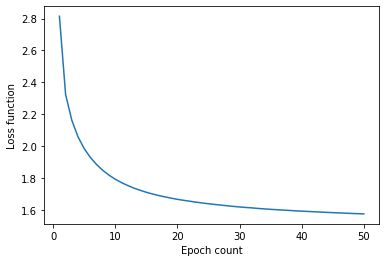

a touchedifat wase a!” strurilitw. tha ar cr _ alon t steded, whabesupalithencrathef wathusthe dithene


In [53]:
def RNN(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss')

model = RNN(len(vocab), emb_dim, rnn_units, BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
history = model.fit(dataset, epochs=num_epochs, callbacks=[checkpoint_callback, es_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model = RNN(vocab_size, emb_dim, rnn_units, 1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

loss_err = history.history['loss']
plt.plot(np.arange(1, 1+num_epochs), loss_err)
plt.xlabel('Epoch count')
plt.ylabel('Loss function')
plt.show()

print(generate_text(model, start_string=u"a "))

Epoch 1/50
192/192 [==============================] - 2s 12ms/step - loss: 2.9473
Epoch 2/50
192/192 [==============================] - 2s 11ms/step - loss: 2.3914
Epoch 3/50
192/192 [==============================] - 2s 11ms/step - loss: 2.2274
Epoch 4/50
192/192 [==============================] - 2s 12ms/step - loss: 2.0802
Epoch 5/50
192/192 [==============================] - 2s 11ms/step - loss: 1.9624
Epoch 6/50
192/192 [==============================] - 2s 11ms/step - loss: 1.8742
Epoch 7/50
192/192 [==============================] - 2s 11ms/step - loss: 1.8079
Epoch 8/50
192/192 [==============================] - 2s 12ms/step - loss: 1.7557
Epoch 9/50
192/192 [==============================] - 2s 11ms/step - loss: 1.7144
Epoch 10/50
192/192 [==============================] - 2s 11ms/step - loss: 1.6812
Epoch 11/50
192/192 [==============================] - 2s 11ms/step - loss: 1.6535
Epoch 12/50
192/192 [==============================] - 2s 11ms/step - loss: 1.6305
Epoch 13/50
1

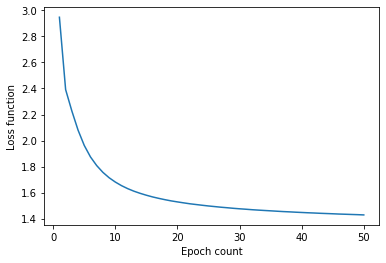

a nobe igonghexte thable d,”“went plo", ond they, as. ou t thecar, aly in.“w t y he ncancoulor.” teves


In [50]:
def GRU(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss')

model = GRU(len(vocab), emb_dim, rnn_units, BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
history = model.fit(dataset, epochs=num_epochs, callbacks=[checkpoint_callback, es_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model = GRU(vocab_size, emb_dim, rnn_units, 1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

loss_err = history.history['loss']
plt.plot(np.arange(1, 1+num_epochs), loss_err)
plt.xlabel('Epoch count')
plt.ylabel('Loss function')
plt.show()

print(generate_text(model, start_string=u"a "))

Epoch 1/50
192/192 [==============================] - 2s 12ms/step - loss: 2.9618
Epoch 2/50
192/192 [==============================] - 2s 12ms/step - loss: 2.4495
Epoch 3/50
192/192 [==============================] - 2s 12ms/step - loss: 2.2923
Epoch 4/50
192/192 [==============================] - 2s 12ms/step - loss: 2.1950
Epoch 5/50
192/192 [==============================] - 2s 12ms/step - loss: 2.1262
Epoch 6/50
192/192 [==============================] - 2s 12ms/step - loss: 2.0707
Epoch 7/50
192/192 [==============================] - 2s 12ms/step - loss: 2.0228
Epoch 8/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9812
Epoch 9/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9459
Epoch 10/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9154
Epoch 11/50
192/192 [==============================] - 2s 12ms/step - loss: 1.8878
Epoch 12/50
192/192 [==============================] - 2s 12ms/step - loss: 1.8630
Epoch 13/50
1

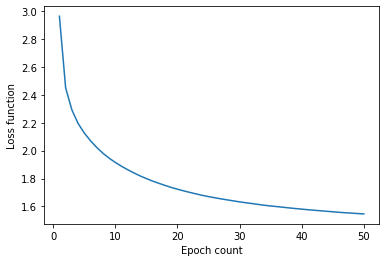

a d’ll,” said alice, wonse who holder’s prote-broth, and misalled truck a confle; the lattered, exchas


In [51]:
def OneLayerLSTM(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss')

model = OneLayerLSTM(len(vocab), emb_dim, rnn_units, BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
history = model.fit(dataset, epochs=num_epochs, callbacks=[checkpoint_callback, es_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model = OneLayerLSTM(vocab_size, emb_dim, rnn_units, 1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

loss_err = history.history['loss']
plt.plot(np.arange(1, 1+num_epochs), loss_err)
plt.xlabel('Epoch count')
plt.ylabel('Loss function')
plt.show()

print(generate_text(model, start_string=u"a "))

Epoch 1/50
192/192 [==============================] - 2s 11ms/step - loss: 2.9770
Epoch 2/50
192/192 [==============================] - 2s 12ms/step - loss: 2.4867
Epoch 3/50
192/192 [==============================] - 2s 12ms/step - loss: 2.3321
Epoch 4/50
192/192 [==============================] - 2s 12ms/step - loss: 2.2314
Epoch 5/50
192/192 [==============================] - 2s 12ms/step - loss: 2.1539
Epoch 6/50
192/192 [==============================] - 2s 12ms/step - loss: 2.0931
Epoch 7/50
192/192 [==============================] - 2s 12ms/step - loss: 2.0418
Epoch 8/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9992
Epoch 9/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9620
Epoch 10/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9296
Epoch 11/50
192/192 [==============================] - 2s 12ms/step - loss: 1.9005
Epoch 12/50
192/192 [==============================] - 2s 12ms/step - loss: 1.8747
Epoch 13/50
1

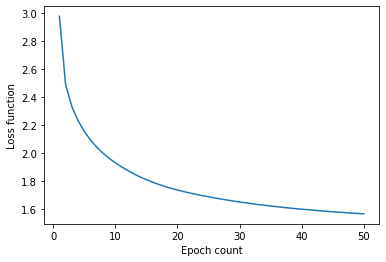

a ,“f, sit’s wire a trejosing lowvertant turn of the place?”“oh i saily surpose the prong agreetheness


In [52]:
def TwoLayersLSTM(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True),
        tf.keras.layers.LSTM(rnn_units/4,return_sequences=True, stateful=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss')

model = OneLayerLSTM(len(vocab), emb_dim, rnn_units, BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
history = model.fit(dataset, epochs=num_epochs, callbacks=[checkpoint_callback, es_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model = OneLayerLSTM(vocab_size, emb_dim, rnn_units, 1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

loss_err = history.history['loss']
plt.plot(np.arange(1, 1+num_epochs), loss_err)
plt.xlabel('Epoch count')
plt.ylabel('Loss function')
plt.show()

print(generate_text(model, start_string=u"a "))